In [ ]:
from IPython.display import YouTubeVideo, Markdown, SVG, Code
from functools import partial
YouTubeVideo_formato = partial(YouTubeVideo, modestbranding=1, disablekb=0,
                               width=640, height=360, autoplay=0, rel=0, showinfo=0)

In [ ]:
%matplotlib inline
%load_ext cython
import numpy as np
import matplotlib.pyplot as plt

# Computación paralela en Python

## Introducción

En las lecciones anteriores hemos visto como ganar rendimiento en operaciones SIMD usando NumPy. Luego aprendimos a conectar con lenguajes de bajo nivel usando Cython

En esta lección veremos una opción para ganar rendimiento en problemas limitados en CPU que sean "separables". Un problema es **separable** si puede dividirse en **subproblemas** que pueden resolverse de forma **independiente**

Al ser independientes significa que podemos resolverlos **al mismo tiempo**, es decir resolver cada uno sin esperar el resultado de los demás

> Arquitectura de computadores: Hoy en día incluso los CPU de sobremesa son en realidad **múltiples CPU** unidos

Es decir que

> Podemos escribir programas que aprovechan los CPU multi-nucleo para resolver problemas separables en un menor tiempo

Esto es lo que llamamos [**computación paralela**](https://computing.llnl.gov/tutorials/parallel_comp/#Whatis) y en la práctica muchos problemas de computación científica (modelamiento, simulación) son paralelizables o incluso "masivamente paralelizables"

Asumiendo que el problema al que nos enfrentamos es limitado en CPU el primer paso es hacer *profiling* para encontrar los cuellos de botella. Luego de esto debemos estudiar las zonas críticas y detectar oportunidades para paralelizar

El objetivo de esto es encontrar sectores del programa que sean separables. Algunas preguntas típicas que pueden servir para esto son:

- ¿Existen ciclos `for` donde las iteraciones son independientes entre si?
- ¿Es posible descomponer la operación o los datos?
- ¿Existe una estructura de tipo pipeline?

Si alguna de estas respuestas es afirmativa entonces lo que resta es usar alguna herramienta de programación paralela para reescribir dicho sector del programa

A continuación veremos algunas herramientas para Python

## El Global interpreter lock (GIL) de Python

El manejo de memoria de CPython no es *thread-safe*. Por esta razón todo código escrito en Python está sujeto a un **[mutex](https://en.wikipedia.org/wiki/Lock_(computer_science))** que lo proteje conocido como **Global Interpreter Lock (GIL)**

El [GIL](https://wiki.python.org/moin/GlobalInterpreterLock) obliga a ejecutar solo un hilo de código Python a la vez. Además el código escrito en Python no tiene control sobre el GIL. Por esta razón no es directo ni fácil que un proceso Python puedo usar múltiples nucleos de CPU

En esta lección exploraremos dos alternativas generales

- **1:** Realizar cómputo paralelo con **múltiples hilos** que comparten memoria. Para esto usaremos `cython` para levantar el GIL y las directivas de `OpenMP` para implementar el paralelismo
- **2:** Realizar cómputo paralelo con **multiples procesos** (fork). En este escenario los procesos tiene su propio espacio de memoria y su propio GIL, por lo que no es necesario usar `cython`. Usaremos la librería `ipyparallel` para implementar le paralelismo


Existe una tercera alternativa más accesible pero exclusiva para hacer **algebra lineal en paralelo** con NumPy

- **3:** Compilar NumPy contra una librería de álgebra lineal de alto rendimiento  como MKL, ATLAS, Openblas. Estas librerías usan código de bajo nivel que levanta el GIL



## Computación multi-hilo con Cython y OpenMP

[OpenMP](https://www.openmp.org/) es una API multiplataforma para computación paralela en C, C++ y Fortran. Por ejemplo en C/C++ se puede escribir un `parallel for` usando directivas de compilador (pragma) de OpenMP 

```c
#pragma omp parallel for
for (i = 0; i < N; i++)
    a[i] = 2 * i;
```

Cython tiene un modulo llamado [`parallel`](http://docs.cython.org/en/latest/src/userguide/parallelism.html) que usa OpenMP como backend. Para ocupar OpenMP desde Cython es necesario 

- instalar OpenMP en el sistema
- compilar el código Cython con `--compile-args=-fopenmp --link-args=-fopenmp`

El modulo provee tres funciones principales

- `parallel(num_threads=None)`: Para crear un contexto de cómputo paralelo
- `threadid()`: Para obtener la id del hilo
- `prange([start,] stop[, step][, nogil=False][, schedule=None[, chunksize=None]][, num_threads=None])`: Un iterador similar `range` pero que implemente un ciclo `for` paralelo

También se pueden usar funciones de OpenMP importando

```cython
cimport openmp
```

El principal requisito es que las funciones paralelas deben liberar el GIL. En Cython podemos liberar el GIL en una sección de código o en una función con el `keyword` [`nogil`](http://docs.cython.org/en/latest/src/userguide/external_C_code.html#nogil)

### Ejemplo: Cálculo paralelo del kernel Gaussiano entre dos vectores

El kernel Gaussiano se define como 

$$
e^{-\gamma (x-y)^2}
$$

En este ejemplo asumiremos $\gamma=1$. Escribamos un código en Cython de referencia y otro paralelo con OpenMP para calcular esta función.

El código Cython de referencia es similar a lo que vimos la clase anterior

In [ ]:
%%cython -f -c=-O3 -c=-march=native
cimport cython

cdef extern from "math.h":
    double exp (double)
    
@cython.boundscheck(False)
@cython.wraparound(False)
def suma_vectores_cython(double [::1] x, double [::1] y, double [::1] z):
    cdef:
        Py_ssize_t i
        int N = x.shape[0]
    for i in range(N):
        z[i] = exp(-(x[i] - y[i])**2)

En el código paralelo realizaremos tres cambios

- Modificamos la magia `%%cython` para compilar contra openmp 
- Agregamos `nogil` en las secciones paralelas. Todas las funciones llamadas en la sección paralela deben liberar el GIL 
- Importamos `cython.parallel.prange` para reemplazar el `range` original. En este caso especifiremos $4$ hilos en `prange`

In [ ]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force 
# Compilamos con directivas OpenMP
cimport cython

from cython.parallel import prange # Importamos prange

cdef extern from "math.h" nogil: # Liberamos el GIL
    double exp (double)
        
@cython.boundscheck(False)
@cython.wraparound(False)
def suma_vectores_openmp(double [::1] x, double [::1] y, double [::1] z):
    cdef:
        Py_ssize_t i
        int N = x.shape[0]
    with nogil: # Liberamos el GIL
        for i in prange(N, num_threads=4): # For paralelo con 4 hilos
            z[i] = exp(-(x[i] - y[i])**2)

A continuación se realiza un profiling en base a datos creados artificialmente

In [ ]:
# Creamos un vector grande
N = 1000000
x = np.random.randn(N)
y = np.random.randn(N)
z = np.empty_like(x)
# Versión numpy
%timeit -r10 -n3 z = np.exp(-(x-y)**2) 

In [ ]:
# Versión cython
%timeit -r10 -n3 suma_vectores_cython(x, y, z)

In [ ]:
# Versión cython con openmp
%timeit -r10 -n3 suma_vectores_openmp(x, y, z)

Finalmente comprobamos que el resultado es idéntico al de NumPy

In [ ]:
z = np.empty_like(x)
suma_vectores_openmp(x, y, z)
np.allclose(np.exp(-(x-y)**2), z)

### Ejemplo: Fractal de Julia en paralelo con Cython y OpenMP

A continuación se muestra una versión paralela del código cython para calcular el fractal de Julia de la lección anterior

In [ ]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force 
import cython
cimport numpy as npc
import numpy as np

from cython.parallel import prange # Importamos prange

ctypedef npc.float32_t TIPOF_t
ctypedef npc.int64_t TIPOI_t

cdef TIPOI_t evaluate_z(TIPOF_t zi, TIPOF_t zr, int maxiters=50, TIPOF_t cr=-0.835, TIPOF_t ci=-0.2321) nogil:
    cdef:
        TIPOI_t nit = 0
        TIPOF_t zi2 = zi**2
        TIPOF_t zr2 = zr**2
        
    while zi2 + zr2 <= 4. and nit < maxiters:
        zi = 2.*zr*zi + ci
        zr = zr2 - zi2 + cr
        zr2 = zr**2
        zi2 = zi**2 
        nit +=1
    return nit

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def make_fractal_cython(int N, TIPOI_t [:, ::1] image_view, int maxiters=50):
    cdef:
        Py_ssize_t i, j
    for i in range(N):
        for j in range(2*N):
            image_view[i, j] = evaluate_z(-1.+i*2./N, -2.+j*2./N, maxiters)
            
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def make_fractal_openmp(int N, TIPOI_t [:, ::1] image_view, int maxiters=50):
    cdef:
        Py_ssize_t i, j
    
    with nogil:
        for i in prange(N, num_threads=4):        
            for j in range(2*N):
                image_view[i, j] = evaluate_z(-1.+i*2./N, -2.+j*2./N, maxiters)

Tiempos de cómputo para implementación serial

In [ ]:
N = 1000
image_cython = np.empty(shape=(N, 2*N), dtype=np.int64)
image_openmp = np.empty(shape=(N, 2*N), dtype=np.int64)

%timeit -r3 -n1 make_fractal_cython(N, image_cython)

e implementación paralela

In [ ]:
%timeit -r3 -n1 make_fractal_openmp(N, image_openmp)

Comparación de los resultados:

In [ ]:
np.allclose(image_cython, image_openmp)

## Computación multi-proceso con IPython: *ipyparallel*

[ipyparallel](https://ipyparallel.readthedocs.io/en/latest/) es un paquete independiente pero complementario de IPython para hacer computación multi-proceso

**Instalación**

Si tienes conda 

```bash
conda install ipyparallel
```

Esto debería instalar en su ambiente los ejecutables  `ipcluster`, `ipcontroller` e `ipengine`. Adicionalmente, en las versiones más nuevas, se crea una pestaña llamada "Ipython clusters" en la interfaz de jupyter

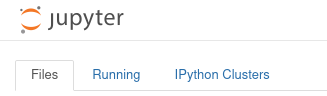

Si la interfaz no se instaló de forma automática se puede usar el comando

```bash
ipcluster nbextension enable
```    
    
**Conceptos y uso básico**

*ipyparallel* considera varios elementos, los más importantes son:

- Engine: Es el encargado de correr código. Es una extensión del kernel de IPython
- Controller: Es una interfaz para comunicarnos con el/los engine/s. La conexión se hace a través del objeto `Client`

Para iniciar un controlador de forma automática podemos abrir un terminal y escribir

```bash
ipcluster start -n 4
```
    
o utilizar los controles que se encuentran en la pestaña "IPython clusters"

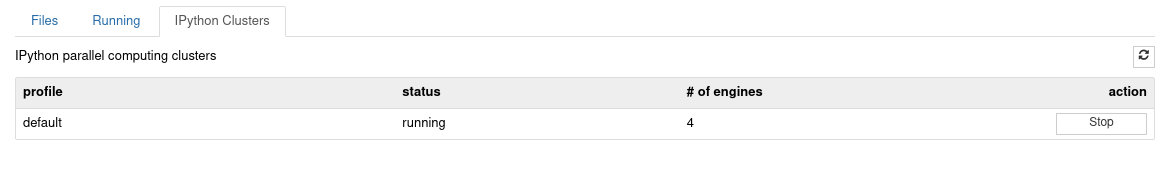

Con esto hemos creado un controlador y cuatro engines, todos en nuestra máquina (localhost)

### Creación de un cliente

In [ ]:
# Importamos ipyparallel
import ipyparallel as ipp
# Creamos la clase cliente
rc = ipp.Client()
# Verificamos que se hayan iniciado nuestro engines
display(rc.ids)

Cada engine tiene una id asociada. Para enviarle trabajo a los engines debemos crear una intefaz llamada [`View`](https://ipyparallel.readthedocs.io/en/latest/details.html#views)

Existen dos tipos de `View`: [*Direct*](https://ipyparallel.readthedocs.io/en/latest/direct.html#) y [*Task*](https://ipyparallel.readthedocs.io/en/latest/task.html#)

- La primera es controlada de forma explicita por el usuario
- La segunda es controlada por el sistema para *balancear la carga*


### Enviando trabajos usando interfaz Directa

Una `View` de tipo *Direct* requiere que el usuario especifique los engines que va a usar. Esto se hace de forma similar a los *slices* en listas/ndarray

Por ejemplo para crear una interfaz que utilice todas las engines, usamos `rc[:]`. En cambio si sólo queremos utilizar las dos primeras engines, usamos `rc[:2]`

La vista puede crearse como bloqueante o no bloqueante (asíncrona) modificando el atributo booleano `block`. Una vista "bloqueante" espera a que el resultado de todos los engines sean retornado para devolver el control

In [ ]:
# Creamos una view con
dview = rc[:]
# Por defecto es asíncrono (no bloqueante)
display(dview.block)
# Lo podemos cambiar con
dview.block = True
display(dview.block)

Los trabajos se envían usando las funciones de la `View` directa

- `apply`, `apply_sync`, `apply_async`: Ejecutan una función con argumentos
- `map`, `map_sync`, `map_async`: Ejecutan una función sobre una secuencia
    
Los apellidos `sync`  y `async` cambian el flag del view momentaneamente

- Cuando trabajamos en forma síncrona el resultado retorna al final de la ejecuación
- Cuando trabajamos de forma asíncrona se retorna un objeto [`AsyncResult`](https://ipyparallel.readthedocs.io/en/latest/asyncresult.html#parallel-asyncresult) que puede ser consultado más tarde por el resultado


### Funciones de Python en paralelo con `apply`

Se ocupa como 

```python
    rc[:].apply(f, *args, **kwargs)
```
    
Por ejemplo usando una función anónima

In [ ]:
dview.apply(lambda x, y: x+" "+y, x="Hola", y="Mundo")

### Compartiendo módulos y datos con los engines

Es importante tener claro que, al contrario del paralelismo multi-hilo, los procesos en los engines no comparten memoria y no ven las variables de nuestro entorno local

Por ejemplo si queremos usar una función del módulo `os`

In [ ]:
#import os # Este import no lo ven los engines

def funcion():
    import os # Este si
    return os.getpid() 

# Cada uno tiene un pid distinto
dview.apply(funcion)

Es posible precargar un módulo en todos los engines con la función `sync_imports()`. Los módulos cargados persisten en el entorno de los engines

In [ ]:
with dview.sync_imports(local=True): 
    import os
# El módulo quedará importado también en nuestro ambiente local

# Ahora ya no necesitamos importar os
def funcion2(): 
    return os.getpid() 

dview.apply(funcion2)

Si queremos limpiar las variables y módulos de los engines podemos usar el método con `clear`

In [ ]:
# Limpiamos el entorno de las engines
dview.clear()
# Ahora el siguiente comando arrojará un NameError
dview.apply(funcion2)

### Traspasando datos a todos los engines

Para enviar un objeto de Python que hayamos definido en el ambiente local podemos usar la función `push`. El objeto tiene que ser un diccionario

Luego podemos usar `pull` si queremos extraer una variable remota

Estas funciones tienen un atributo llamado `targets` que permite apuntar los objetos a un subconjunto de *engines*

In [ ]:
a = 100 # Esto no existe dentro de los engines

dview.push({'a': a}) # Ahora está en todos los engines

def funcion3(): 
    return a**2

dview.apply(funcion3)

In [ ]:
# Digamos que quiero recuperar la variable 'a' pero sólo de los dos primeros engines
dview.pull('a', targets=[0, 1])

### Distribuyendo datos a los engines

Si queremos distribuir datos en los engines podemos usar `scatter`. Esto sirve por ejemplo para procesar elementos de una lista en paralelo. `scatter` recibe un string con el nombre de la variable (tal como lo recibirá cada proceso) y un arreglo con los valores de la variable

Para recuperar resultados a partir de los engine podemos usar `gather`

In [ ]:
# Una lista con 7 elementos que será distribuida en los 4 engines usando scatter
dview.scatter('c', np.array(range(10)))

def funcion3(): 
    global y # Creo una variable en el workspace del engine
    y = c**2 # Le doy un valor
    return y

display(dview.apply(funcion3))

In [ ]:
# Recuperamos la salida con gather
display(dview.gather('y'))

También es posible distribuir arreglos de NumPy usando `scatter`. Notar que los arreglos de NumPy no se copian, se traspasan *read-only*

In [ ]:
datos = np.random.randn(100, 100)
dview.scatter('x', datos)

def funcion4(): 
    # data[0, 0] = 0 # No podemos modificar los valores!
    return x.shape

# Se particiona en 4 matrices por fila (row-major)
dview.apply(funcion4)

Si queremos hacer modificaciones de los arreglos tenemos que hacer una copia local

In [ ]:
datos = np.random.randn(1000, 1000)
dview.scatter('x', datos)

def funcion5(): 
    global x
    if not x.flags.writeable:
        x = x.copy()
    x[0, 0] = 0 # No podemos hacer esto!
    return x

# Se particiona en 4 matrices por fila (row-major)
datos = np.concatenate(dview.apply(funcion5))

# Se modificaron los datos originales
display(datos[0, 0])

### Cómputo paralelo con `map`

La función *built-in* `map` de Python aplica una función sobre una secuencia de datos uno por uno. En general, si vemos un `map` en nuestro código, paralelizarlo es muy sencillo

La librería `ipyparallel` provee una versión paralela de [`map`](https://ipyparallel.readthedocs.io/en/latest/api/ipyparallel.html#ipyparallel.DirectView.map) que se ocupa sobre una vista

```python
rc[:].map(f, *sequences, block=self.block)
```   


In [ ]:
# Map de Python
resultado_serial = list(map(lambda x: x, range(32)))

# Map de ipyparallel
resultado_paralelo = dview.map(lambda x: x, range(32))

# Resultados
np.allclose(resultado_serial, resultado_paralelo)

Podemos entregar iteradores para más de un argumento. Los iteradores deben ser del mismo largo (de lo contrario la secuencia más corta manda)

In [ ]:
dview.map(lambda x, y, z: x + y + z, range(10), range(10), range(10))

Si tenemos una función con algunos argumentos escalares (no iterables) podemos usar partial

In [ ]:
from functools import partial

def function_args(x, y, gamma=1):
    import numpy as np
    return np.exp(-gamma*(x-y)**2)

dview.map(partial(function_args, gamma=2), np.random.randn(10), np.random.randn(10))

### Funciones remotas y paralelas con decoradores

Podemos crear una función que es siempre ejecutada por los engines usando el decorador `remote`. Por ejemplo:

In [ ]:
@dview.remote(block=True)
def funcion():
    import os
    return os.getpid()

funcion()

La función se ejecutó en los cuatro engines sin llamar a `dview.apply` o `dview.map` explicitamente

De la misma forma, si tenemos una función que trabaja sobre un arreglo de forma *element-wise* podemos usar el decorador `parallel` para distribuir su carga a los engines. Por ejemplo

In [ ]:
@dview.parallel(block = True)
def funcion(x):
    return x

# Los datos se particionan en 4 grupos (uno por engine)
# Los grupos no son todos del mismo tamaño
funcion(range(10))

Esto también se pueden usar arreglos de numpy

In [ ]:
A = np.random.random((1000, 1000))

@dview.parallel(block=True)
def pmul(A,B):
    return A*B

(A*A == pmul(A,A)).all()

### Resultado asíncronos

El resultado asíncrono es un objeto de clase [`AsyncResult`](https://ipyparallel.readthedocs.io/en/latest/asyncresult.html#parallel-asyncresult). Sus funciones más relevantes son

- `ready` : Retorna un booleano con el estado de la tarea
- `get` : Retorna el resultado

Así se lanza una tarea asíncrona

In [ ]:
res_async = dview.map_async(lambda x: x**2, range(10))
# ¿Está listo mi tarea?
res_async.ready()

In [ ]:
while True:
    # Puedo hacer cómputo aquí mientras espero que termine mi tarea
    if res_async.ready():
        # Recupero el resultado
        res = res_async.get()
        break
    
res

### Otras funcionalidades de ipyparallel no vistas en esta lección

- [Magias de ipyparallel](https://ipyparallel.readthedocs.io/en/latest/magics.html)
- Balance de carga automático en ipyparallel con la [interfaz Task](https://ipyparallel.readthedocs.io/en/latest/task.html#)
- [Dependencias entre procesos paralelos](https://ipyparallel.readthedocs.io/en/latest/dag_dependencies.html)


También es posible conectar controladores y engines en distintas máquinas para hacer **computación distribuida** en base a [MPI](https://ipyparallel.readthedocs.io/en/latest/mpi.html)  usando [`ipengine` e `ipcontroller`](https://ipyparallel.readthedocs.io/en/latest/process.html#using-the-ipcontroller-and-ipengine-commands)